<a href="https://colab.research.google.com/github/kaka-lin/yolov3-tf2/blob/master/knowledge/load_darknet_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
sys.path.append('../')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from models.yolov3 import Yolov3
from utils.yolo_utils import (
    read_classes,
    read_anchors,
    generate_colors,
    yolo_eval,
    draw_outputs
)
from utils.common import preprocess_image

%load_ext autoreload
%autoreload 2

print(tf.__version__)

2.9.1


## Model

In [2]:
model = Yolov3(classes=80)
model.summary()

Model: "yolov3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 yolo_darknet (Functional)      ((None, None, None,  40620640    ['input[0][0]']                  
                                 256),                                                            
                                 (None, None, None,                                               
                                 512),                                                            
                                 (None, None, None,                                          

## Convert Darknet weights  to TensorFlow weights

In [3]:
YOLOV3_LAYER_LIST = [
    'yolo_darknet',
    'yolo_conv_0',
    'yolo_output_0',
    'yolo_conv_1',
    'yolo_output_1',
    'yolo_conv_2',
    'yolo_output_2',
]

In [4]:
def load_darknet_weights(model, weights_file):
    with open(weights_file, 'rb') as wf:
        major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
        layers = YOLOV3_LAYER_LIST
        
        for layer_name in layers:
            sub_model = model.get_layer(layer_name)
            for i, layer in enumerate(sub_model.layers):
                if not layer.name.startswith('conv2d'):
                    continue

                # BatchNormalization layer
                batch_norm = None    
                if i + 1 < len(sub_model.layers) and \
                        sub_model.layers[i + 1].name.startswith('batch_norm'):
                    batch_norm = sub_model.layers[i + 1]
                
                print("{}/{} {}".format(
                    sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

                filters = layer.filters
                kerner_size = layer.kernel_size[0]
                input_dim = layer.input_shape[-1]

                if batch_norm is None:
                    conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
                else:
                    # darknet [beta, gamma, mean, variance]
                    bn_weights = np.fromfile(
                        wf, dtype=np.float32, count=4*filters)
                    # tf [gamma, beta, mean, variance]
                    bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

                # darknet shape (out_dim, input_dim, height, width)
                conv_shape = (filters, input_dim, kerner_size, kerner_size)
                conv_weights = np.fromfile(
                    wf, dtype=np.float32, count=np.product(conv_shape))

                # tf shape (height, width, in_dim, out_dim)
                conv_weights = conv_weights.reshape(
                    conv_shape).transpose([2, 3, 1, 0])

                if batch_norm is None:
                    layer.set_weights([conv_weights, conv_bias])
                else:
                    layer.set_weights([conv_weights])
                    batch_norm.set_weights(bn_weights)

            print("Completed!")
    print("Weights loaded!")

In [5]:
darknet_weights_file = '../model_data/yolov3.weights'
tensorflow_weights_file = '../checkpoints/yolov3.tf'
load_darknet_weights(model, darknet_weights_file)

# Save weights
model.save_weights(tensorflow_weights_file)
print('Weights saved!')

yolo_darknet/conv2d bn
yolo_darknet/conv2d_1 bn
yolo_darknet/conv2d_2 bn
yolo_darknet/conv2d_3 bn
yolo_darknet/conv2d_4 bn
yolo_darknet/conv2d_5 bn
yolo_darknet/conv2d_6 bn
yolo_darknet/conv2d_7 bn
yolo_darknet/conv2d_8 bn
yolo_darknet/conv2d_9 bn
yolo_darknet/conv2d_10 bn
yolo_darknet/conv2d_11 bn
yolo_darknet/conv2d_12 bn
yolo_darknet/conv2d_13 bn
yolo_darknet/conv2d_14 bn
yolo_darknet/conv2d_15 bn
yolo_darknet/conv2d_16 bn
yolo_darknet/conv2d_17 bn
yolo_darknet/conv2d_18 bn
yolo_darknet/conv2d_19 bn
yolo_darknet/conv2d_20 bn
yolo_darknet/conv2d_21 bn
yolo_darknet/conv2d_22 bn
yolo_darknet/conv2d_23 bn
yolo_darknet/conv2d_24 bn
yolo_darknet/conv2d_25 bn
yolo_darknet/conv2d_26 bn
yolo_darknet/conv2d_27 bn
yolo_darknet/conv2d_28 bn
yolo_darknet/conv2d_29 bn
yolo_darknet/conv2d_30 bn
yolo_darknet/conv2d_31 bn
yolo_darknet/conv2d_32 bn
yolo_darknet/conv2d_33 bn
yolo_darknet/conv2d_34 bn
yolo_darknet/conv2d_35 bn
yolo_darknet/conv2d_36 bn
yolo_darknet/conv2d_37 bn
yolo_darknet/conv2d_38 b

##   Testing pre-trained Darknet weights


1/1 [==============================] - 2s 2s/step
detections:
	person, 0.9794398546218872, [802.637   234.60329 924.9627  508.48962]
	person, 0.9577058553695679, [760.25464 225.26727 835.44086 485.6693 ]
	person, 0.9206016063690186, [284.75443 219.99498 329.56592 335.03796]
	person, 0.8943182826042175, [121.898415 192.80878  165.483    330.052   ]
	person, 0.8069238066673279, [206.89694 193.00381 245.71526 321.45847]
	person, 0.7676388621330261, [ 42.00898 219.69083  75.37179 300.257  ]
	person, 0.6876460909843445, [267.58987 226.84364 310.6086  328.2648 ]
	car, 0.9990807771682739, [319.54898 222.84892 481.17606 344.8452 ]
	bus, 0.9982948899269104, [399.58444  85.57832 726.41064 336.81644]
	bus, 0.9915417432785034, [ 820.17017  130.54549 1196.4908   345.64795]
	traffic light, 0.5859587788581848, [345.00415 165.83904 357.76828 182.53366]
	backpack, 0.5647851228713989, [732.5534  260.96466 768.003   333.92627]


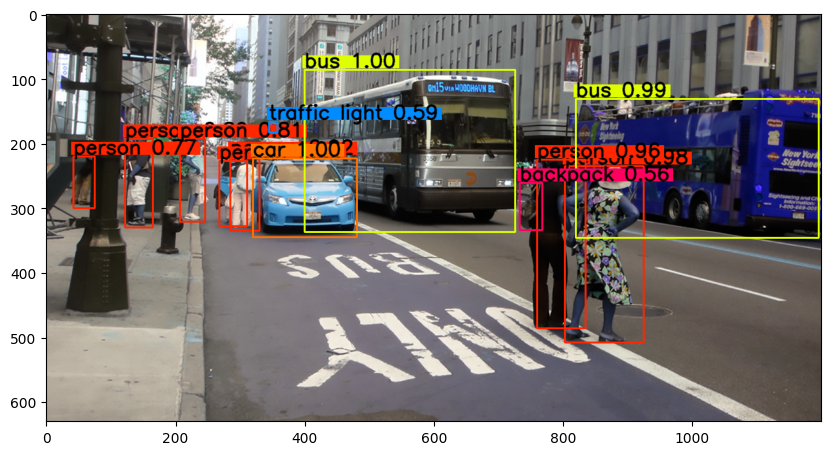

In [6]:
yolo = Yolov3(classes=80)
yolo.load_weights('../checkpoints/yolov3.tf')

# Load classes and anchors
class_names = read_classes('../model_data/coco_classes.txt')
anchors = read_anchors('../model_data/yolov3_anchors.txt')

# Generate colors for drawing bounding boxes.
colors = generate_colors(class_names)

# 選一張圖像
img_filepath = "../data/street.jpg"

# 使用OpenCV讀入圖像
image = cv2.imread(img_filepath) # 載入圖像
image_shape = image.shape[:2] # h, w

# 進行圖像輸入的前處理
size = 416
keep_aspect_ratio = True
input_dims = (size, size)
input_image = preprocess_image(image, input_dims, keep_aspect_ratio=keep_aspect_ratio)

# 進行圖像偵測
yolo_outputs = yolo.predict(input_image)
scores, boxes, classes = yolo_eval(
    yolo_outputs,
    anchors,
    image_shape,
    input_dims,
    letterbox=keep_aspect_ratio)

print("detections:")
for i in range(scores.shape[0]):
    print("\t{}, {}, {}".format(
        class_names[int(classes[i])], scores[i], boxes[i]
    ))

# Draw bounding boxes on the image file
image = draw_outputs(image, (scores, boxes, classes), class_names, colors)

# Save
cv2.imwrite("../model_data/output.jpg", image)

plt.figure(figsize=(10, 10))
plt.imshow(image)